TODO: Write project description and motivation

Не забути розповісти як в мене закінчувалася оперативна память

In [ ]:
# Clone the repository
!git clone https://github.com/AndriyDragan/HawkEye.git

Cloning into 'HawkEye'...
remote: Enumerating objects: 11565, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 11565 (delta 10), reused 5 (delta 0), pack-reused 11537
Receiving objects: 100% (11565/11565), 1.13 GiB | 27.27 MiB/s, done.
Resolving deltas: 100% (7356/7356), done.
Updating files: 100% (11532/11532), done.


In [ ]:
import os
import itertools
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

data_dir = 'HawkEye/Data'

# Define function to read annotations
def read_annotations(xml_path):
    # Parse the XML file
    tree = ET.parse(xml_path)

    # Get the root element of the XML tree
    root = tree.getroot()

    # Initialize an empty list to store the annotations
    annotations = []

    # Loop through <object> elements in the XML
    for obj in root.findall('object'):

        # Extract the label from the <name> element
        name = obj.find('name').text

        # Extract the bounding box coordinates from the <bndbox> element
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))

    # Return the list of annotations
    return annotations

# Define function to read images and annotations
def read_data(file_names, data_dir):
    data = []
    dims = []
    labels = []

    # Loop over the file names extracted and read the images and annotations
    # Exlude incorrect images
    for file_name in file_names:

        # Get the paths to the files
        img_path = os.path.join(data_dir, 'Images', file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Labels', 'Horizontal Bounding Boxes', file_name + '.xml')

        # Read the image
        img = Image.open(img_path)

        # Exclude 4-channel images
        if len(np.array(img).shape) != 3 or np.array(img).shape[2] != 3:
            continue

        # Extract annotations
        annotations = read_annotations(xml_path)

        # Get the dimensions of all objects and store it for later use
        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append((width, height))
            labels.append(annot[0])

        data.append((img_path, annotations))

    return data, labels, dims


In [ ]:
# Get the list of filenames (without extension)
file_names = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'Images'))]

# Read the data
train_data, labels, dims = read_data(file_names, data_dir)

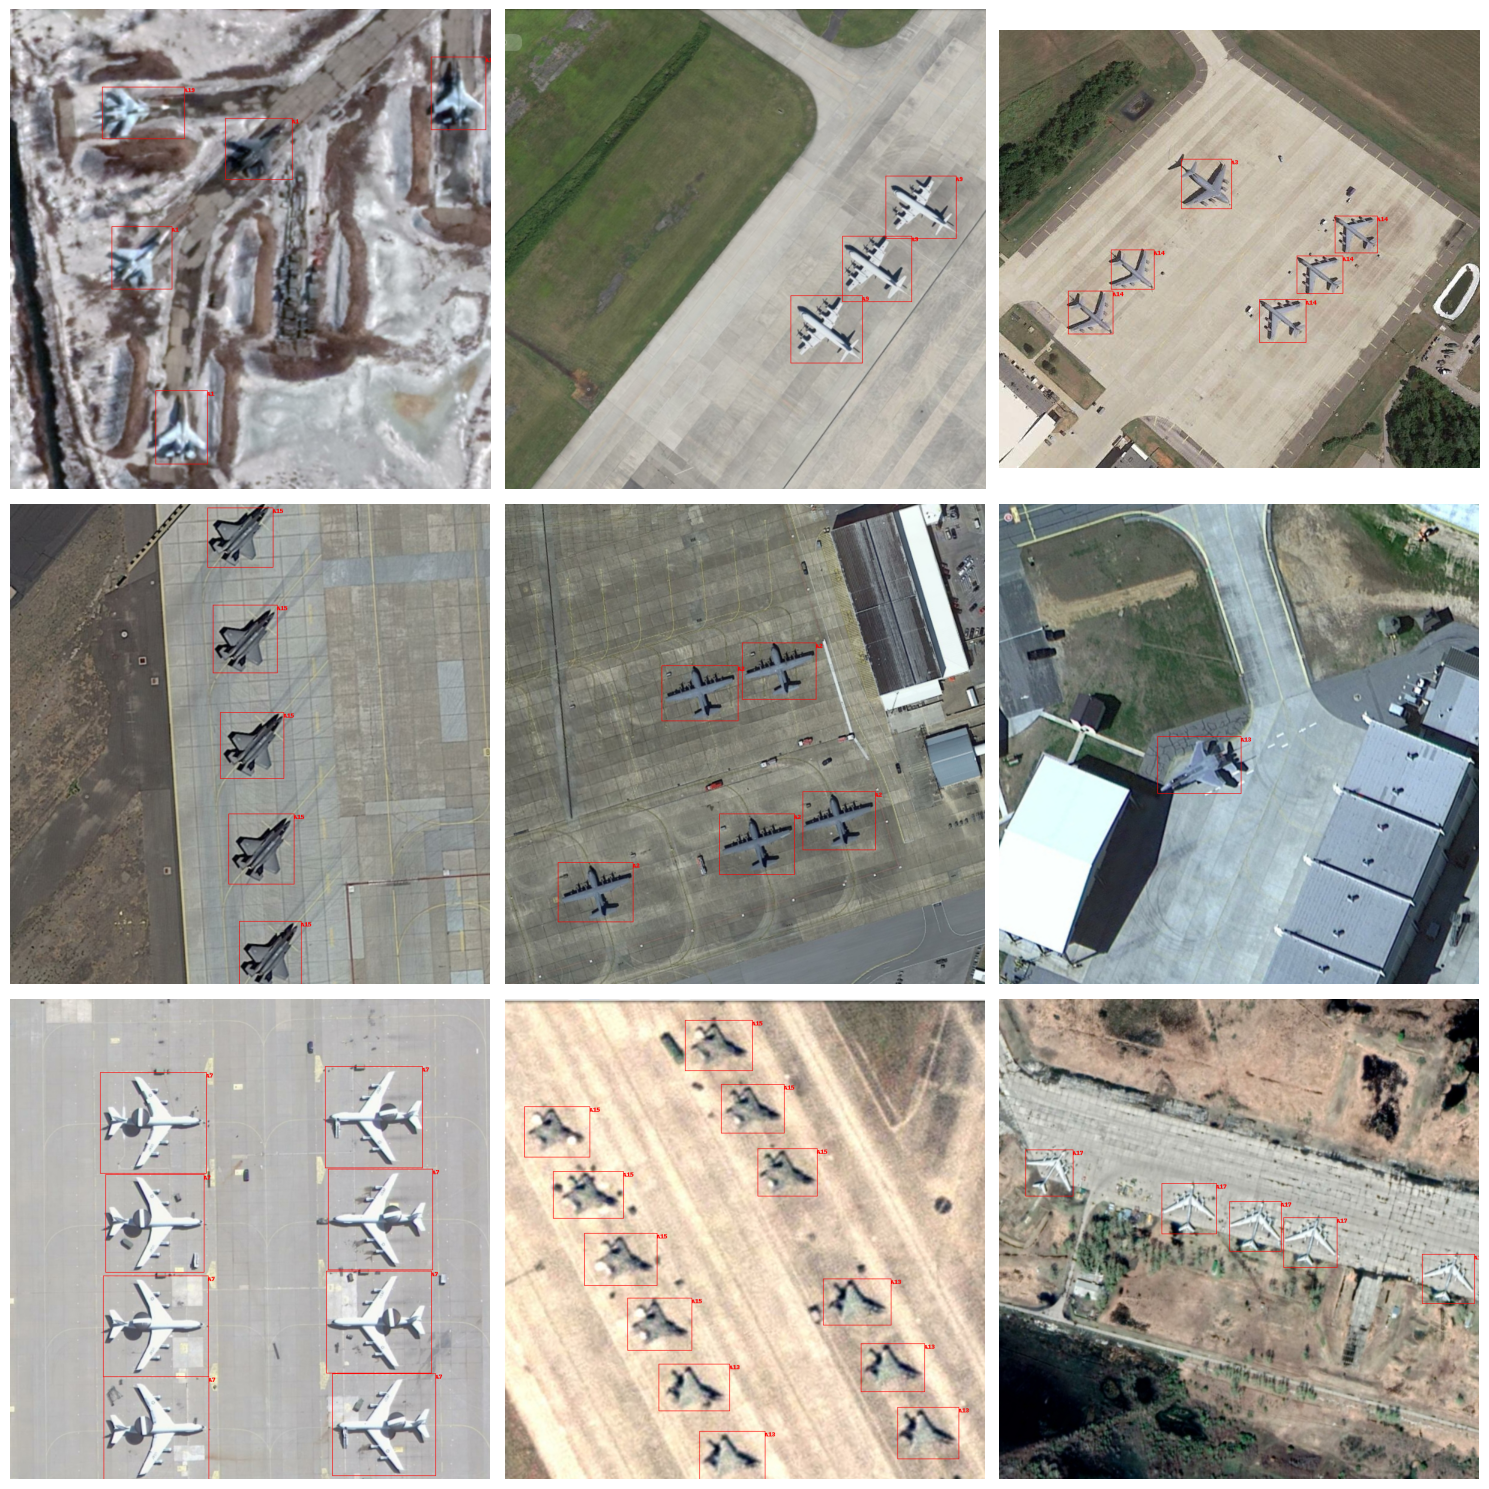

In [ ]:
# Display random samples
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax in axes:
    idx = np.random.randint(0, len(train_data) - 1)
    img_path = train_data[idx][0]
    annotations = train_data[idx][1]
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    # Draw annotations on the image
    for obj in annotations:
        label, (xmin, ymin, xmax, ymax) = obj
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red')
        font_size = 100
        draw.text((xmax, ymin), label, fill='red')

    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

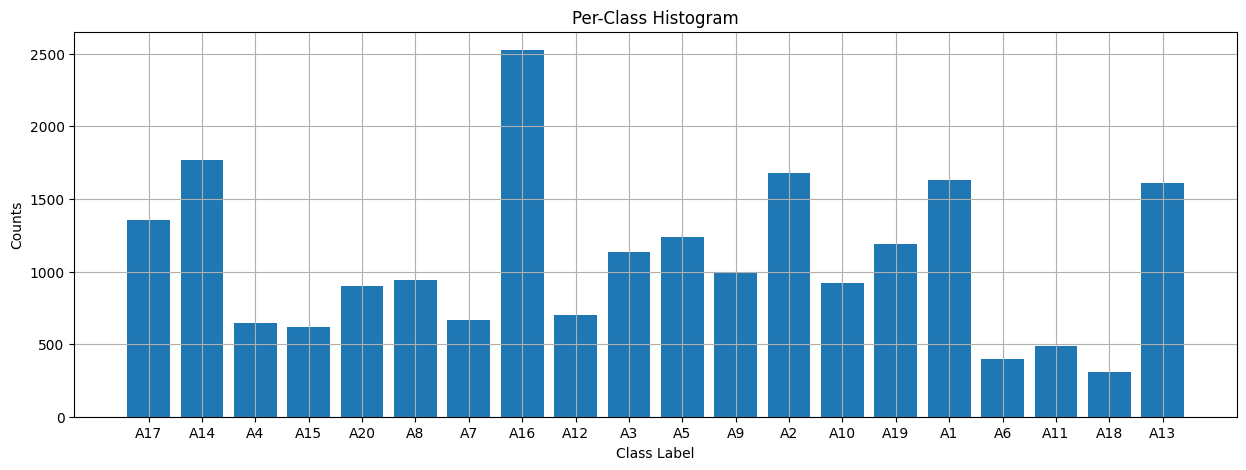

In [ ]:
# Compute and plot the per-class histogram
hist = Counter(labels)
plt.figure(figsize=(15, 5))
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram')
plt.show()


In [ ]:
# Print the per-class distribution
hist = Counter(labels)
sorted_hist = dict(sorted(hist.items()))

# Display the per-class distribution as text
for class_label, count in sorted_hist.items():
    print(f'Class {class_label}: {count} instances')

Class A1: 1629 instances
Class A10: 924 instances
Class A11: 486 instances
Class A12: 699 instances
Class A13: 1611 instances
Class A14: 1768 instances
Class A15: 617 instances
Class A16: 2525 instances
Class A17: 1352 instances
Class A18: 308 instances
Class A19: 1192 instances
Class A2: 1678 instances
Class A20: 900 instances
Class A3: 1132 instances
Class A4: 642 instances
Class A5: 1236 instances
Class A6: 396 instances
Class A7: 667 instances
Class A8: 944 instances
Class A9: 996 instances


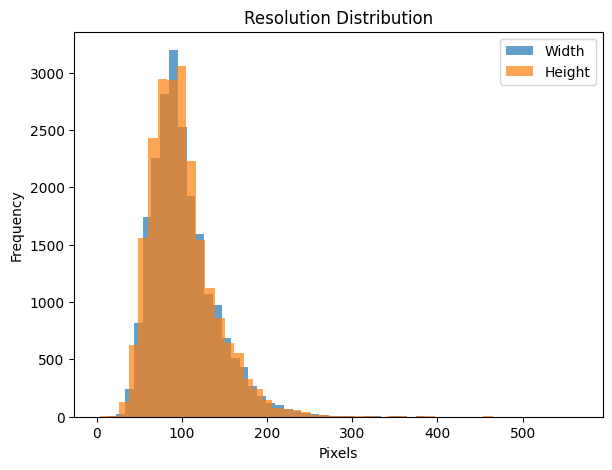

In [ ]:
# Analyze resolution distribution
resolutions = pd.DataFrame(dims, columns=['Width', 'Height'])

# Plot resolution distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(resolutions['Width'], bins=50, alpha=0.7, label='Width')
plt.hist(resolutions['Height'], bins=50, alpha=0.7, label='Height')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Resolution Distribution')
plt.legend()
plt.show()

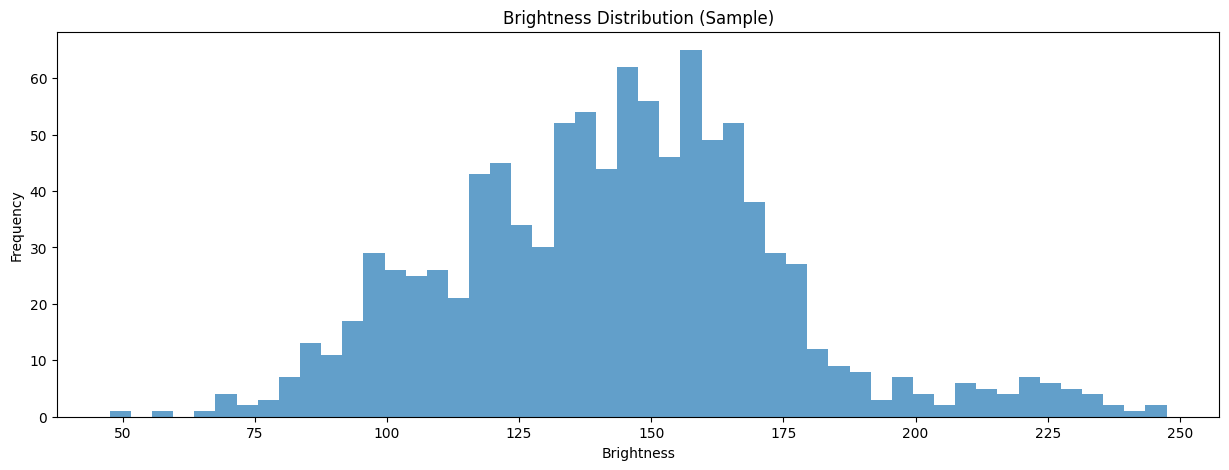

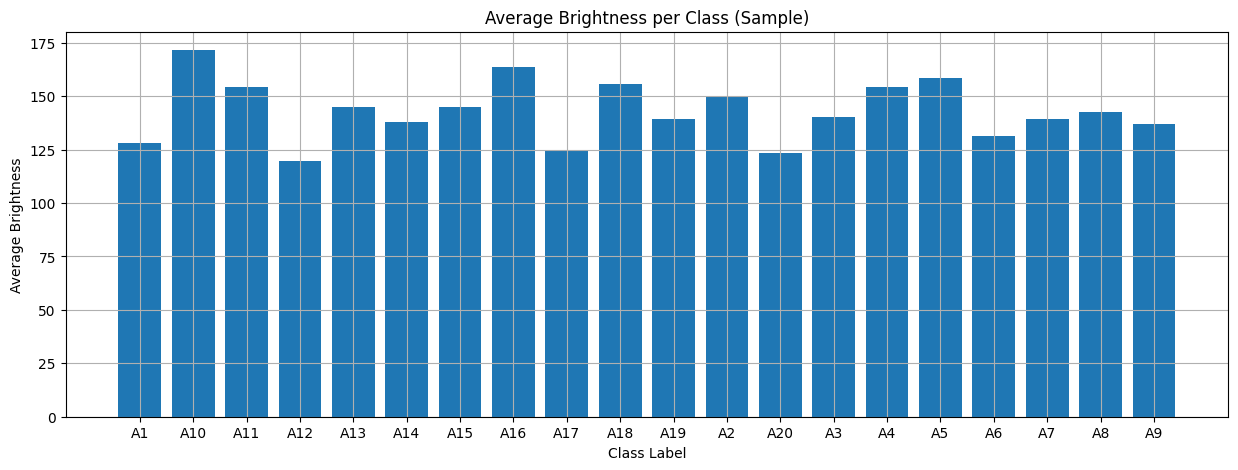

In [ ]:
# Sample a random subset of the dataset for brightness analysis
sample_size = 1000
sample_data_indices = np.random.choice(len(train_data), sample_size, replace=False)
brightness = []

for idx in sample_data_indices:
    img_path = train_data[idx][0]
    img = Image.open(img_path).convert('L')
    brightness.append(np.mean(np.array(img)))

sample_brightness = pd.DataFrame(brightness, columns=['Brightness'])

# Plot brightness distribution for the sample
plt.figure(figsize=(15, 5))
plt.hist(sample_brightness['Brightness'], bins=50, alpha=0.7)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Brightness Distribution (Sample)')
plt.show()

# Brightness distribution per class for the sample
sample_labels = [train_data[idx][1][0][0] for idx in sample_data_indices]
brightness_per_class = pd.DataFrame({'ClassId': sample_labels, 'Brightness': brightness}).groupby('ClassId')['Brightness'].mean()

plt.figure(figsize=(15, 5))
plt.bar(brightness_per_class.index, brightness_per_class.values)
plt.xlabel('Class Label')
plt.ylabel('Average Brightness')
plt.title('Average Brightness per Class (Sample)')
plt.grid(True)
plt.show()



In [ ]:
# Define function to pad images
def pad_img(img):
    old_size = img.size
    desired_size = (32, 32)
    max_dim = max(old_size)
    padded = Image.new("RGB", (max_dim, max_dim))
    x = (max_dim - old_size[0]) // 2
    y = (max_dim - old_size[1]) // 2
    padded.paste(img, (x, y))
    out_img = padded.resize(desired_size)
    return out_img

# Define function to extract objects from images
def extract_obj(img, annotations):
    objects = []
    labels = []
    for label, b_box in annotations:
        labels.append(label)
        roi = img.crop(b_box)
        objects.append(roi)
    labels = np.array(labels)
    return objects, labels

# Preprocessing function for CNN
def preprocessing(data, batch_size=500):
    X_temp = []
    y_temp = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        X_batch, y_batch = [], []
        for img, annotations in batch_data:
            objects, labels = extract_obj(img, annotations)
            padded = [pad_img(obj) for obj in objects]
            X_batch.extend(padded)
            y_batch.extend(labels)
        X_temp.extend(X_batch)
        y_temp.extend(y_batch)
    orig_labels = list(itertools.chain(*y_temp))
    orig_labels_np = np.array(orig_labels).reshape(-1, 1)
    encoder = OneHotEncoder()
    y = encoder.fit_transform(orig_labels_np).toarray()
    X_list = [np.array(obj) / 255.0 for obj in X_temp]
    X = np.array(X_list)
    return X, y, orig_labels_np

In [ ]:
# Preprocess the data for CNN
X, y, orig_labels = preprocessing(train_data)
n_labels = y.shape[1]

# Train/Test Split for CNN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [21702, 55786]

In [ ]:
# Define the simple CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_labels, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
history_cnn = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_val, y_val))

In [ ]:
# Show training history
h = history_cnn.history
epochs = range(len(h['loss']))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122)
plt.plot(epochs, h['accuracy'], '.-', epochs, h['val_accuracy'], '.-')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])


YOLO

In [ ]:
!pip install -U ultralytics

import torch
from ultralytics import YOLO

# Load YOLO model
yolo_model = YOLO('yolov5s.pt')

# Define your custom dataset and train the model
# data.yaml should be created based on your dataset structure
yolo_model.train(data='data.yaml', epochs=30, imgsz=640)

# Validate the model
yolo_results = yolo_model.val()

# Show results
print(yolo_results)

In [ ]:
Faster R-CNN

In [ ]:
# Load Faster R-CNN model
fasterrcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(set(labels)) + 1  # +1 for background
in_features = fasterrcnn_model.roi_heads.box_predictor.cls_score.in_features
fasterrcnn_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Training and validation code for Faster R-CNN
# This code should include dataloader setup and training loop

RetinaNet

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn

# Load the pre-trained RetinaNet model
retinanet_model = retinanet_resnet50_fpn(pretrained=True)
num_classes = len(set(labels)) + 1  # +1 for background
in_features = retinanet_model.head.classification_head.conv[0].in_channels
num_anchors = retinanet_model.head.classification_head.num_anchors
retinanet_model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetHead(in_features, num_anchors, num_classes)

# Training RetinaNet
# Similar training and validation code here

EfficientDet

In [ ]:
!pip install -U effdet

from effdet import create_model
from effdet.evaluator import evaluate

# Load EfficientDet model
effdet_model = create_model('tf_efficientdet_d0', num_classes=len(set(labels)) + 1)

# Training and validation code for EfficientDet
# Similar training and validation code here

Evaluation of the models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Placeholder for storing evaluation results
evaluation_results = {}

# Function to evaluate a model
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    mAP = average_precision_score(y_val, y_pred, average='macro')
    return precision, recall, f1, mAP

# Evaluate CNN model
precision, recall, f1, mAP = evaluate_model(cnn_model, X_val, y_val)
evaluation_results['CNN'] = (precision, recall, f1, mAP)

# Evaluate YOLO model
# Similar code for YOLO, Faster R-CNN, RetinaNet, and EfficientDet

Inference Time

In [ ]:
import time

# Function to measure inference time
def measure_inference_time(model, X_val):
    start_time = time.time()
    model.predict(X_val)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

# Measure inference time for CNN model
inference_time_cnn = measure_inference_time(cnn_model, X_val)
evaluation_results['CNN'] += (inference_time_cnn,)

# Measure inference time for YOLO model
# Similar code for YOLO, Faster R-CNN, RetinaNet, and EfficientDet

Conclusion

In [ ]:
# Print evaluation results
for model_name, metrics in evaluation_results.items():
    precision, recall, f1, mAP, inference_time = metrics
    print(f"Model: {model_name}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"Mean Average Precision (mAP): {